In [2]:
import matplotlib.pyplot as plt
import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data

import os

In [3]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../prediction-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [4]:
# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)

In [5]:
# printing the frame ranges that make up each scene
scene_frame_indexes = []
for i in range(len(zarr_dataset.scenes)):
    scene_frame_indexes.append([zarr_dataset.scenes[i][0][0], zarr_dataset.scenes[i][0][1]])

print(scene_frame_indexes)

[[0, 248], [248, 497], [497, 746], [746, 995], [995, 1244], [1244, 1493], [1493, 1742], [1742, 1991], [1991, 2240], [2240, 2489], [2489, 2738], [2738, 2987], [2987, 3236], [3236, 3485], [3485, 3734], [3734, 3983], [3983, 4232], [4232, 4481], [4481, 4730], [4730, 4979], [4979, 5228], [5228, 5477], [5477, 5725], [5725, 5973], [5973, 6221], [6221, 6469], [6469, 6717], [6717, 6965], [6965, 7213], [7213, 7461], [7461, 7709], [7709, 7957], [7957, 8205], [8205, 8453], [8453, 8701], [8701, 8949], [8949, 9197], [9197, 9445], [9445, 9693], [9693, 9941], [9941, 10189], [10189, 10437], [10437, 10685], [10685, 10933], [10933, 11182], [11182, 11431], [11431, 11680], [11680, 11929], [11929, 12177], [12177, 12425], [12425, 12673], [12673, 12921], [12921, 13169], [13169, 13417], [13417, 13665], [13665, 13913], [13913, 14161], [14161, 14409], [14409, 14657], [14657, 14905], [14905, 15153], [15153, 15401], [15401, 15649], [15649, 15897], [15897, 16145], [16145, 16393], [16393, 16641], [16641, 16889], [16

In [6]:
# measurements from Example 9 of https://www.kalmanfilter.net/multiExamples.html
position = [[-393.66, 300.4], 
            [-375.93, 301.78], 
            [-351.04, 295.1], 
            [-328.96, 305.19], 
            [-299.35, 301.06], 
            [-273.36, 302.05], 
            [-245.89, 300], 
            [-222.58, 303.57], 
            [-198.03, 296.33], 
            [-174.17, 297.65], 
            [-146.32, 297.41], 
            [-123.72, 299.61], 
            [-103.47, 299.6], 
            [-78.23, 302.39], 
            [-52.63, 295.04], 
            [-23.34, 300.09], 
            [25.96, 294.72], 
            [49.72, 298.61], 
            [76.94, 294.64], 
            [95.38, 284.88], 
            [119.83, 272.82], 
            [144.01, 264.93], 
            [161.84, 251.46], 
            [180.56, 241.27], 
            [201.42, 222.98],
            [222.62, 203.73],
            [239.4, 184.1],
            [252.51, 166.12],
            [266.26, 138.71],
            [271.75, 119.71],
            [277.4, 100.41],
            [294.12, 79.76],
            [301.23, 50.62],
            [291.8, 32.99],
            [299.89, 2.14]]

In [29]:
# kalmanFilterSetup() sets up the matrices needed to use the multivariate Kalman Filter
def kalmanFilterSetup():

    # setting up matrices for Kalman Filter
    # initial state matrix, "unknown" vehicle location so we set pos, vel, acc to 0
    x = np.array([[680],
                [0],
                [0],
                [-2180],
                [0],
                [0]])

    # since velocity and acceleration is unknown, a high estimate uncertainty is set, resulting in a high Kalman Gain
    # calculate these values
    P = np.array([[100, 0, 0, 0, 0, 0],
                [0, 80, 0, 0, 0, 0],
                [0, 0, 10, 0, 0, 0],
                [0, 0, 0, 100, 0, 0],
                [0, 0, 0, 0, 80, 0],
                [0, 0, 0, 0, 0, 10]])

    # t = measurement period in seconds
    t = 1
    acc_std_dev = 0.2

    # state transition matrix, kinematic equations for position, velocity, and acceleration
    F = np.array([[1, t, 0.5*(t**2), 0, 0,          0], 
                [0, 1,          t, 0, 0,          0], 
                [0, 0,          1, 0, 0,          0], 
                [0, 0,          0, 1, t, 0.5*(t**2)], 
                [0, 0,          0, 0, 1,          t], 
                [0, 0,          0, 0, 0,          1]])

    # process noise matrix
    Q = np.array([[0.25, 0.5, 0.5,    0,   0,   0], 
                [ 0.5,   1,   1,    0,   0,   0], 
                [ 0.5,   1,   1,    0,   0,   0],
                [   0,   0,   0, 0.25, 0.5, 0.5],
                [   0,   0,   0,  0.5,   1,   1],
                [   0,   0,   0,  0.5,   1,   1]]) * (acc_std_dev**2)

    # measurement error variance
    xvar = 30
    yvar = 30
    
    # measurement uncertainty matrix
    R = np.array([[xvar, 0], 
                [0, yvar]])

    H = np.array([[1, 0, 0, 0, 0, 0], 
                [0, 0, 0, 1, 0, 0]])

    I = np.array([[1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])

    # initialization
    P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q
    
    return(x, F, P, R, H, Q, I,)

In [8]:
# kalmanFilter() implements the Kalman Filter on the inputted measurements for the given number of iterations
def kalmanFilter(measurements, iterations, output):
    estimates = []
    predictions = []

    x, F, P, R, H, Q, I = kalmanFilterSetup()

    for i in range(iterations):
        z = np.array([[measurements[i][0]],
                      [measurements[i][1]]])
        if output: print(z)
        
        # Kalman Gain calculation
        # K = (P * H_T) * (H * P * H_T + R)^-1
        K = np.matmul(np.matmul(P, np.transpose(H)), 
                      np.linalg.inv(np.matmul(np.matmul(H, P), np.transpose(H)) + R))
        if output: print(K)

        # current state estimation
        # x = x + K * (z - H * x)
        x = x + np.matmul(K, (z - np.matmul(H, x)))
        estimates.append([x[0][0],x[3][0]])
        if output: print(x)

        # update estimate uncertainty
        # P = (I - K * H) * P * (I - K * H)_T + K * R * K_T
        # IKH = (I - K * H)
        IKH = I - np.matmul(K, H)
        P = np.matmul(np.matmul(IKH, P), np.transpose(IKH)) + np.matmul(np.matmul(K, R), np.transpose(K))
        if output: print(P)

        # predict state and update estimate uncertainty
        # x = F * x
        # P = F * P * F_T + Q
        x = np.matmul(F, x)
        P = np.matmul(np.matmul(F, P), np.transpose(F)) + Q 
        predictions.append([x[0][0],x[3][0]])
        if output: print(x)
        if output: print(P)

    # formatting
    estimates = np.array(estimates)
    predictions = np.array(predictions)
    
    return (estimates, predictions)

In [9]:
estimates, predictions = kalmanFilter(measurements=position, iterations=35, output=False)

In [33]:
# plotData() plots the measured data, as well as the estimates and predictions from the Kalman Filter, and plots them on a scatter plot

# plot ellipse estimate/prediction covariance
def plotData(measurements, estimates, predictions):
    
    measurements_x = [pos[0] for pos in measurements]
    measurements_y = [pos[1] for pos in measurements]

    estimates_x = [estimate[0] for estimate in estimates]
    estimates_y = [estimate[1] for estimate in estimates]

    predictions_x = [prediction[0] for prediction in predictions]
    predictions_y = [prediction[1] for prediction in predictions]

    fig, ax = plt.subplots()
    ax.scatter(measurements_x, measurements_y, label="measurements", s=20)
    ax.scatter(estimates_x, estimates_y, label="estimates", s=15, alpha=0.5)
    ax.scatter(predictions_x, predictions_y, label="predictions", s=15, alpha=0.5)
    ax.legend()
    fig.set_size_inches(15, 12)
    plt.show()

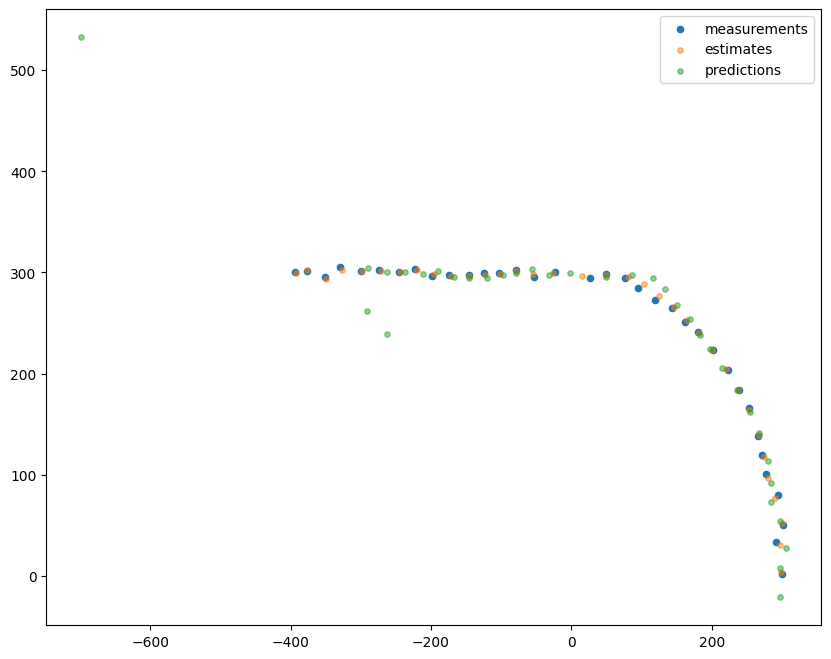

In [11]:
plotData(measurements=position, estimates=estimates, predictions=predictions)

In [12]:
position_AV = []
for i in range(0, 248):
#for i in range(scene_frame_indexes[0][0], scene_frame_indexes[0][1]):
    position_AV.append(ego_dataset[i]["centroid"])

In [30]:
estimates_AV, predictions_AV = kalmanFilter(measurements=position_AV, iterations=len(position_AV), output=False)

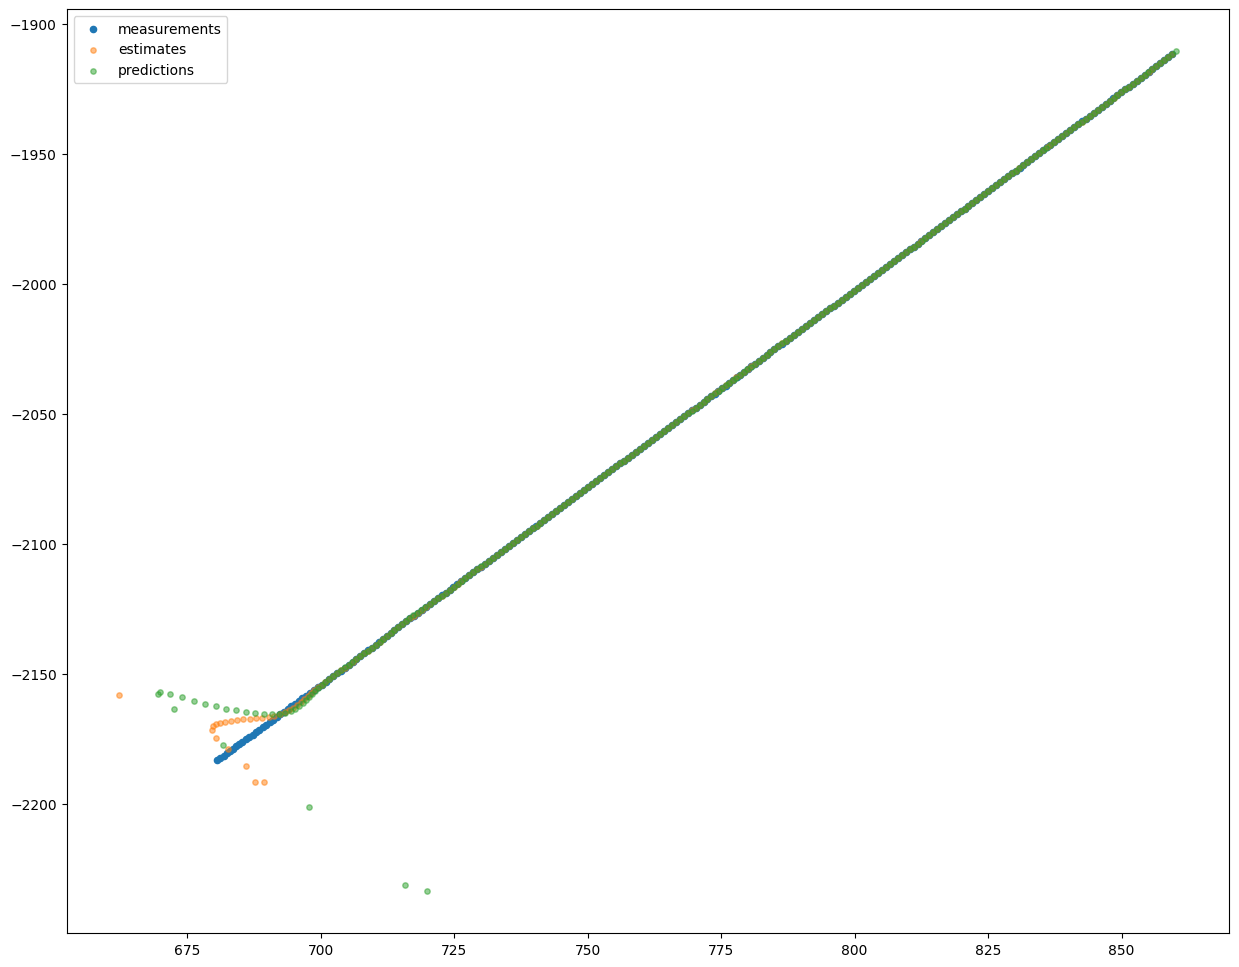

In [34]:
plotData(measurements=position_AV, estimates=estimates_AV, predictions=predictions_AV)

In [32]:
position_AV[0]

array([  680.61975098, -2183.32763672])